# Impor Packages

In [1]:
!pip install datetime
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Collection

In [2]:
df = pd.read_csv('Salinan Online Retail Data.csv', header=0)
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [3]:
df.shape

(461773, 7)

In [4]:
df.isnull().sum()

,0
order_id,0
product_code,0
product_name,2718
quantity,0
order_date,0
price,0
customer_id,100920


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data Cleaning

In [6]:
df_clean = df.copy()

# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]


# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)


# membuat kolom date
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date
# membuat kolom year_month
df_clean['year_month'] = pd.to_datetime(df_clean['order_date']).dt.to_period('M')
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str.contains('C', case=False), 'cancelled', 'delivered')


# menghapus outlier
#from scipy import stats
#df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
#df_clean = df_clean.reset_index(drop=True)
#df_clean.head()

In [7]:
df_clean.drop_duplicates(keep='first', inplace=True)

In [8]:
df_clean.shape

(354417, 11)

In [9]:
df_clean.isnull().sum()

,0
order_id,0
product_code,0
product_name,0
quantity,0
order_date,0
price,0
customer_id,0
date,0
year_month,0
amount,0


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354417 entries, 0 to 360841
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype    
---  ------        --------------   -----    
 0   order_id      354417 non-null  object   
 1   product_code  354417 non-null  object   
 2   product_name  354417 non-null  object   
 3   quantity      354417 non-null  int64    
 4   order_date    354417 non-null  object   
 5   price         354417 non-null  float64  
 6   customer_id   354417 non-null  object   
 7   date          354417 non-null  object   
 8   year_month    354417 non-null  period[M]
 9   amount        354417 non-null  float64  
 10  order_status  354417 non-null  object   
dtypes: float64(2), int64(1), object(7), period[M](1)
memory usage: 32.4+ MB


In [11]:
df_clean['quantity'].skew(), df_clean['amount'].skew()

(76.5074016306891, 95.83922462776215)

In [12]:
#df_clean.agg(['skew', 'kurtosis']).transpose()

In [13]:
#plt.figure(figsize=(10,8))
#plt.subplot(2,2,1)
#sns.histplot(data=df_clean, x="quantity", kde=True)

#plt.subplot(2,2,2)
#sns.histplot(data=df_clean, x="amount", kde=True)

#plt.show()

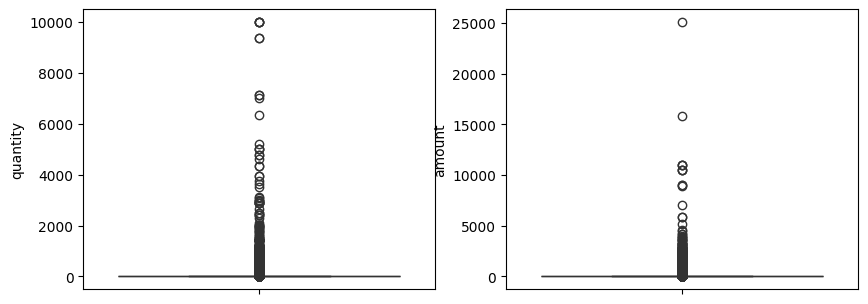

In [14]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.boxplot(data = df_clean['quantity'], color='#108A99')

plt.subplot(2,2,2)
sns.boxplot(data = df_clean['amount'], color='#108A99')

plt.show()

In [15]:
#fig = plt.figure(figsize=(6, 4))
#plt.hist(df_clean['quantity'], density=True, bins=50, color='#FF6961')
#plt.show()

In [16]:
#fig = plt.figure(figsize=(6, 4))
#plt.hist(df_clean['amount'], density=True, bins=50, color='#FF6961')
#plt.show()

In [17]:
def outlier_skewed(data, variabel, jarak):

    # Mendefinisikan IQR
    IQR = data[variabel].quantile(0.75) - data[variabel].quantile(0.25)

    # Mendefinisikan batas_bawah dan batas_atas
    batas_bawah = data[variabel].quantile(0.25) - (IQR * jarak)
    batas_atas = data[variabel].quantile(0.75) + (IQR * jarak)

    return batas_bawah, batas_atas

In [18]:
# Mengimplementasikan fungsi outlier_skewed untuk variabel 'quantity'
q_lower_limit, q_upper_limit = outlier_skewed(df_clean, 'quantity', 1.5)

# Melihat batas bawah dan batas atas
q_lower_limit, q_upper_limit

(-13.0, 27.0)

In [19]:
# Mengimplementasikan fungsi outlier_skewed untuk variabel 'amount'
a_lower_limit, a_upper_limit = outlier_skewed(df_clean, 'amount', 1.5)

# Melihat batas bawah dan batas atas
a_lower_limit, a_upper_limit

(-16.150000000000002, 38.25)

In [20]:
df_clean = df_clean[df_clean['quantity'] < q_upper_limit]
df_clean = df_clean[df_clean['amount'] < a_upper_limit]
df_clean.shape

(316578, 11)

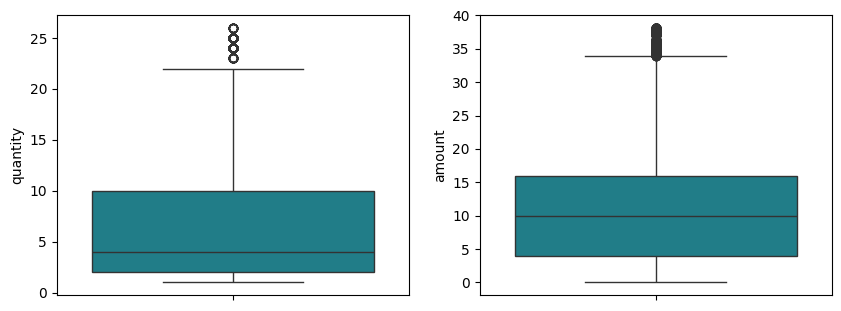

In [21]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.boxplot(data = df_clean['quantity'], color='#108A99')

plt.subplot(2,2,2)
sns.boxplot(data = df_clean['amount'], color='#108A99')

plt.show()

#Binning of Prices

In [22]:
df_clean['price'].min(), df_clean['price'].max()

(0.001, 36.6)

In [23]:
#Binning dengan panjang masing-masing sesuai interval tertentu
interval_range = pd.interval_range(start=min(df_clean['price']), freq=5, end=max(df_clean['price']))
df_clean['bin1'] = pd.cut(df_clean['price'], bins=interval_range, include_lowest=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]"
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]"
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]"
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]"
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]"


In [24]:
interval_range

IntervalIndex([(0.001, 5.001], (5.001, 10.001], (10.001, 15.001], (15.001, 20.001], (20.001, 25.001], (25.001, 30.001], (30.001, 35.001]], dtype='interval[float64, right]')

In [25]:
bin1_summary = df_clean.groupby('bin1').agg(row_cnt=('product_code','count'), min_price=('price','min'), max_price=('price','max'))
bin1_summary['bin_interval'] = bin1_summary['max_price'] - bin1_summary['min_price']
bin1_summary

,row_cnt,min_price,max_price,bin_interval
bin1,,,,
"(0.001, 5.001]",272623,0.06,5.0,4.94
"(5.001, 10.001]",36387,5.18,10.0,4.82
"(10.001, 15.001]",5992,10.08,15.0,4.92
"(15.001, 20.001]",1362,15.58,20.0,4.42
"(20.001, 25.001]",108,20.30,25.0,4.70
"(25.001, 30.001]",74,25.88,30.0,4.12
"(30.001, 35.001]",6,31.78,35.0,3.22


In [26]:
#Binning dengan panjang masing-masing batas bin dan label ditentukan sendiri
bins_edges = [0, 5, 30, 40]
category = ['Cheap','Medium','Expensive']
df_clean['bin2'] = pd.cut(df_clean['price'], bins=bins_edges, labels=category, include_lowest=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]",Cheap
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]",Cheap
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]",Cheap
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]",Cheap


In [27]:
bin2_summary = df_clean.groupby('bin2').agg(row_cnt=('product_code','count'), min_price=('price','min'), max_price=('price','max'))
bin2_summary['bin_interval'] = bin2_summary['max_price'] - bin2_summary['min_price']
bin2_summary

,row_cnt,min_price,max_price,bin_interval
bin2,,,,
Cheap,272636,0.001,5.0,4.999
Medium,43923,5.180,30.0,24.820
Expensive,19,31.780,36.6,4.820


In [28]:
#fig = plt.figure(figsize=(6, 4))
#ax = sns.barplot(x='bin2', y='row_cnt', data=bin2_summary, hue='bin2', palette='pastel', dodge=False)
#plt.xlabel('Price Binning')
#plt.ylabel('Row Count')
#plt.title('Price of Product Code (pd.cut)')
#for c in ax.containers:
#    ax.bar_label(c, label_type='edge', padding=1)
#plt.show()

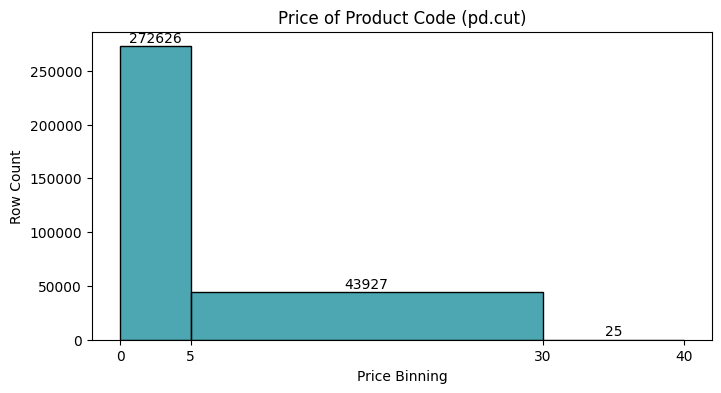

In [29]:
plt.figure(figsize = (8,4))
h = sns.histplot(df_clean['price'], bins=bins_edges, color="#108A99")
h.set_xticks(bins_edges)
h.bar_label(h.containers[0], label_type='edge', padding=1)
plt.xlabel('Price Binning')
plt.ylabel('Row Count')
plt.title('Price of Product Code (pd.cut)')
plt.show()

In [30]:
#Binning dengan banyaknya bins tertentu dan banyaknya anggota setiap bin sama
category = ['Cheap','Medium','Expensive']
df_clean['bin3'] = pd.qcut(df_clean['price'], q=3, labels=category)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]",Cheap,Expensive
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]",Cheap,Medium
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]",Cheap,Expensive
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium,Expensive
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]",Cheap,Expensive


In [31]:
bin3_summary = df_clean.groupby('bin3').agg(row_cnt=('product_code','count'), min_price=('price','min'), max_price=('price','max'))
bin3_summary['bin_interval'] = bin3_summary['max_price'] - bin3_summary['min_price']
bin3_summary

,row_cnt,min_price,max_price,bin_interval
bin3,,,,
Cheap,107775,0.001,1.25,1.249
Medium,122355,1.270,2.95,1.680
Expensive,86448,2.980,36.60,33.620


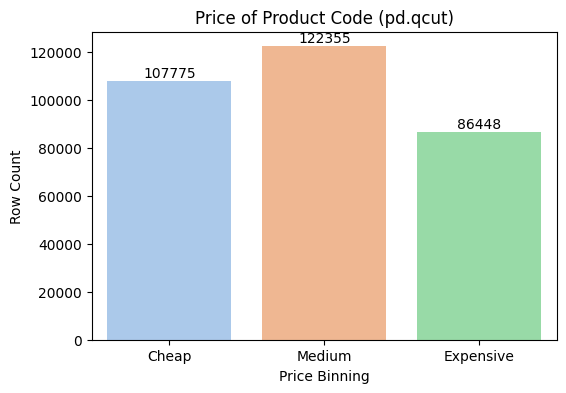

In [32]:
fig = plt.figure(figsize=(6, 4))
ax = sns.barplot(x='bin3', y='row_cnt', data=bin3_summary, hue='bin3', palette='pastel', dodge=False)
plt.xlabel('Price Binning')
plt.ylabel('Row Count')
plt.title('Price of Product Code (pd.qcut)')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', padding=1)
plt.show()

In [33]:
#Binning dengan banyaknya label tertentu
category = ['Cheap','Medium','Expensive']
df_clean['bin4'] = pd.cut(df_clean['price'], 3, labels=category, include_lowest=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3,bin4
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]",Cheap,Medium,Cheap
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]",Cheap,Expensive,Cheap
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium,Expensive,Cheap
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap


In [34]:
bin4_summary = df_clean.groupby('bin4').agg(row_cnt=('product_code','count'), min_price=('price','min'), max_price=('price','max'))
bin4_summary['bin_interval'] = bin4_summary['max_price'] - bin4_summary['min_price']
bin4_summary

,row_cnt,min_price,max_price,bin_interval
bin4,,,,
Cheap,310358,0.001,12.16,12.159
Medium,6065,12.340,24.00,11.660
Expensive,155,24.600,36.60,12.000


In [35]:
#Binning dengan banyaknya bins tertentu
bins = np.linspace(min(df_clean['price']), max(df_clean['price']), 10)
df_clean['bin5'] = pd.cut(df_clean['price'], bins, include_lowest=True)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3,bin4,bin5
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(4.068, 8.134]"
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]",Cheap,Medium,Cheap,"(0.0, 4.068]"
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(4.068, 8.134]"
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium,Expensive,Cheap,"(4.068, 8.134]"
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(0.0, 4.068]"


In [36]:
bin5_summary = df_clean.groupby('bin5').agg(row_cnt=('product_code','count'), min_price=('price','min'), max_price=('price','max'))
bin5_summary['bin_interval'] = bin5_summary['max_price'] - bin5_summary['min_price']
bin5_summary

,row_cnt,min_price,max_price,bin_interval
bin5,,,,
"(0.0, 4.068]",252163,0.001,4.00,3.999
"(4.068, 8.134]",46657,4.250,7.97,3.720
"(8.134, 12.201]",11538,8.200,12.16,3.960
"(12.201, 16.267]",4867,12.340,16.00,3.660
"(16.267, 20.334]",1154,16.300,20.30,4.000
"(20.334, 24.4]",44,21.850,24.00,2.150
"(24.4, 28.467]",78,24.600,27.50,2.900
"(28.467, 32.533]",60,28.500,32.29,3.790
"(32.533, 36.6]",17,34.950,36.60,1.650


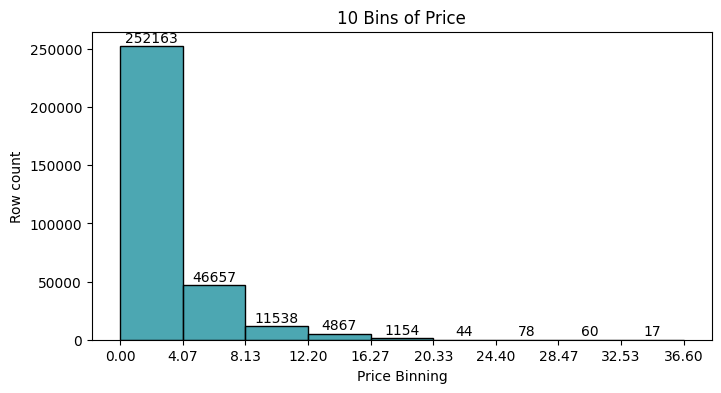

In [37]:
plt.figure(figsize = (8,4))
h = sns.histplot(df_clean['price'], bins=bins, color="#108A99")
h.set_xticks(bins)
h.bar_label(h.containers[0], label_type='edge', padding=1)
plt.xlabel('Price Binning')
plt.ylabel('Row count')
plt.title('10 Bins of Price')
plt.show()

#Grouping with Case Statements (products: Tea and Coffee)

In [38]:
# Price range of tea
df_clean[df_clean['product_name'].str.contains('tea')]['price'].min(), df_clean[df_clean['product_name'].str.contains('tea')]['price'].max()

(0.25, 24.95)

In [39]:
# Price range of coffee
df_clean[df_clean['product_name'].str.contains('coffee')]['price'].min(), df_clean[df_clean['product_name'].str.contains('coffee')]['price'].max()

(0.85, 30.0)

In [40]:
df_clean['price_class'] = np.select(
    [(df_clean['product_name'].str.lower().str.contains('tea')) & (df_clean['price']<=5),
     (df_clean['product_name'].str.lower().str.contains('tea')) & (df_clean['price'].between(5,15)),
     (df_clean['product_name'].str.lower().str.contains('tea')) & (df_clean['price']>15),
     (df_clean['product_name'].str.lower().str.contains('coffee')) & (df_clean['price']<=10),
     (df_clean['product_name'].str.lower().str.contains('coffee')) & (df_clean['price'].between(10,20)),
     (df_clean['product_name'].str.lower().str.contains('coffee')) & (df_clean['price']>20)],
    ['1. Cheap Tea', '2. Medium Tea', '3. Expensive Tea', '1. Cheap Coffee', '2. Medium Coffee',
     '3. Expensive Coffee'],
    default='Undetermined'
)
df_clean.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3,bin4,bin5,price_class
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,2010-01,4.25,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(4.068, 8.134]",Undetermined
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,2010-01,5.10,delivered,"(0.001, 5.001]",Cheap,Medium,Cheap,"(0.0, 4.068]",Undetermined
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,2010-01,8.50,delivered,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(4.068, 8.134]",Undetermined
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium,Expensive,Cheap,"(4.068, 8.134]",2. Medium Tea
8,C493426,22109,full english breakfast plate,1,2010-01-04 10:41:00,3.39,16550.0,2010-01-04,2010-01,3.39,cancelled,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(0.0, 4.068]",Undetermined


In [41]:
price_class_summary = df_clean.groupby('price_class', as_index=False).agg(row_cnt=('product_code','nunique'), min_price=('price','min'), max_price=('price','max')).sort_values('price_class', ascending=True)
price_class_summary['price_interval'] = price_class_summary['max_price'] - price_class_summary['min_price']
price_class_summary

,price_class,row_cnt,min_price,max_price,price_interval
0,1. Cheap Coffee,17,0.850,5.95,5.100
1,1. Cheap Tea,72,0.250,4.95,4.700
2,2. Medium Coffee,1,12.750,12.75,0.000
3,2. Medium Tea,16,5.450,14.95,9.500
4,3. Expensive Coffee,2,30.000,30.00,0.000
5,3. Expensive Tea,2,16.950,24.95,8.000
6,Undetermined,3723,0.001,36.60,36.599


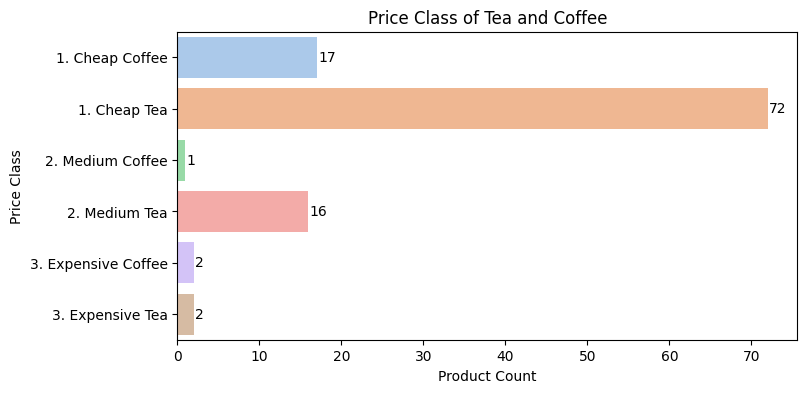

In [42]:
price_class_summary = price_class_summary[price_class_summary['price_class'] != 'Undetermined']
fig = plt.figure(figsize=(8,4))
ax = sns.barplot(x='row_cnt', y='price_class', data=price_class_summary, hue='price_class', palette='pastel', dodge=False, orient='h')
plt.xlabel('Product Count')
plt.ylabel('Price Class')
plt.title('Price Class of Tea and Coffee')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', padding=1)
plt.show()

#EDA

In [43]:
df_clean['year_month'] = df_clean['year_month'].astype(str)
df_date_summary = df_clean.groupby('year_month', as_index=False).agg(order_cnt=('order_id','nunique'))
df_date_summary

,year_month,order_cnt
0,2010-01,1005
1,2010-02,1062
2,2010-03,1517
3,2010-04,1274
4,2010-05,1420
5,2010-06,1470
6,2010-07,1366
7,2010-08,1242
8,2010-09,1570
9,2010-10,2055


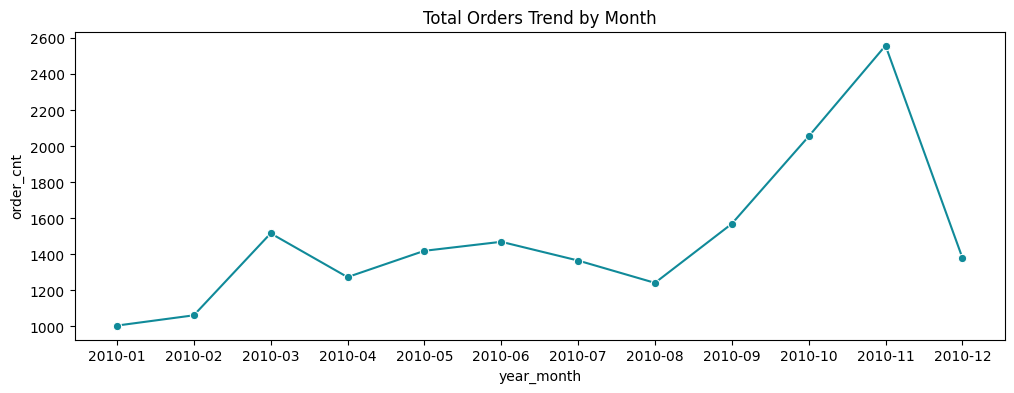

In [44]:
fig = plt.figure(figsize=(12, 4))
sns.lineplot(data = df_date_summary, x='year_month', y='order_cnt', marker='o', color='#108A99')
plt.title('Total Orders Trend by Month')
plt.show()

In [45]:
pd.pivot_table(df_clean, index='date',
               columns='order_status', values=['order_id','amount'],
               aggfunc={'order_id': pd.Series.nunique,
                        'amount': np.sum},
               fill_value=0
)

amount            order_id          
order_status cancelled delivered cancelled delivered
date                                                
2010-01-04      190.28   4214.07         9        18
2010-01-05       82.50   8055.61         3        27
2010-01-06        0.00   2879.53         0        10
2010-01-07      508.07   9863.20        31        33
2010-01-08       21.90   6135.95         1        28
...                ...       ...       ...       ...
2010-12-19       17.60   3621.46         2        15
2010-12-20      441.73   6820.92        21        37
2010-12-21      165.20   3458.41         8        18
2010-12-22       25.80   2181.30         4        10
2010-12-23      138.10   1925.91         7        12

[298 rows x 4 columns]

In [46]:
df_status_summary = df_clean.groupby('order_status', as_index=False).agg(order_cnt=('order_id','nunique'),total_amount=('amount','sum')).sort_values('order_cnt', ascending=False)
df_status_summary

,order_status,order_cnt,total_amount
1,delivered,14762,3415204.733
0,cancelled,3159,64465.500


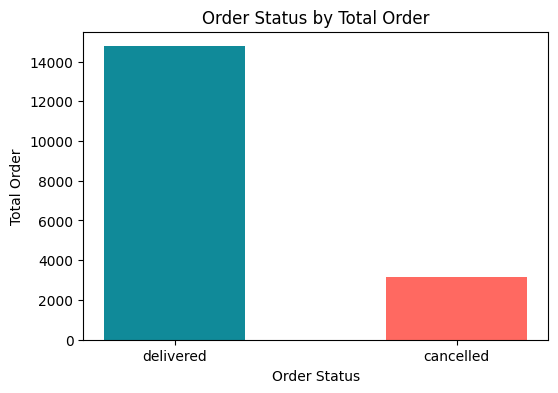

In [47]:
fig = plt.figure(figsize=(6, 4))
plt.bar(df_status_summary['order_status'], df_status_summary['order_cnt'],
        color=['#108A99','#FF6961'], width=0.5)
plt.xlabel('Order Status')
plt.ylabel('Total Order')
plt.title('Order Status by Total Order')
plt.show()

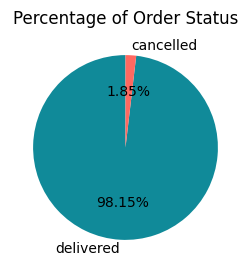

In [48]:
fig = plt.figure(figsize=(4,3))
plt.pie(df_status_summary['total_amount'], labels=df_status_summary['order_status'],
        startangle=90, autopct='%1.2f%%', colors=['#108A99','#FF6961'])
plt.title('Percentage of Order Status')
plt.show()

In [49]:
df_qty_summary = df_clean.groupby(['price_class','order_status'], as_index=False).agg(total_quantity=('quantity','sum'),total_amount=('amount','sum')).sort_values(['order_status','price_class'], ascending=[False,True])
df_qty_summary = df_qty_summary[df_qty_summary.price_class != 'Undetermined']
df_qty_summary

,price_class,order_status,total_quantity,total_amount
1,1. Cheap Coffee,delivered,8367,17935.83
3,1. Cheap Tea,delivered,70125,117060.19
4,2. Medium Coffee,delivered,53,675.75
6,2. Medium Tea,delivered,2759,22992.15
7,3. Expensive Coffee,delivered,2,60.00
8,3. Expensive Tea,delivered,6,117.70
0,1. Cheap Coffee,cancelled,227,510.62
2,1. Cheap Tea,cancelled,730,1491.73
5,2. Medium Tea,cancelled,156,1229.32


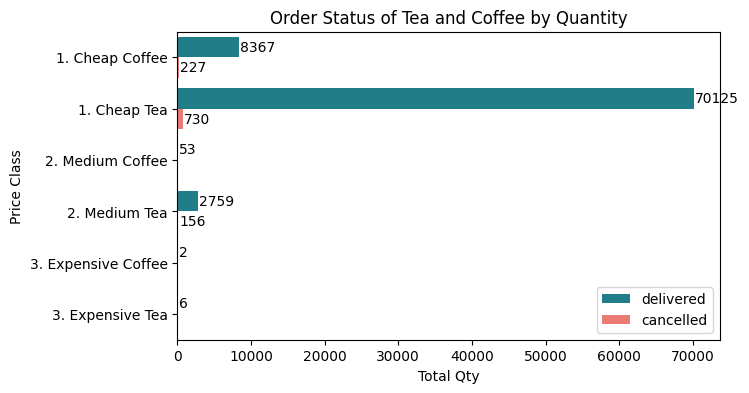

In [50]:
colors=['#108A99','#FF6961']
fig = plt.figure(figsize=(7,4))
#plt.bar(df_qty_summary['order_status'], df_qty_summary['total_quantity'], color=colors, width=0.5)
ax = sns.barplot(x='total_quantity', y='price_class', data=df_qty_summary, hue='order_status', palette=colors, dodge=True, orient='h')
plt.xlabel('Total Qty')
plt.ylabel('Price Class')
plt.title('Order Status of Tea and Coffee by Quantity')
ax.legend(loc='lower right')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', padding=1)
plt.show()

#Correlation Variables

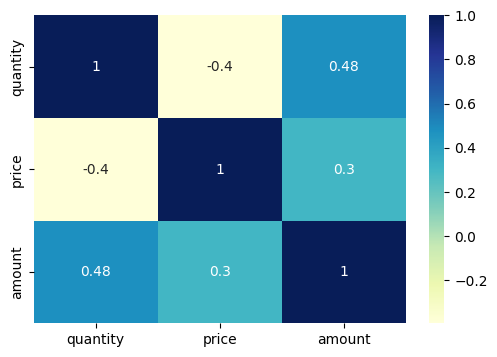

In [51]:
#Heatmap Correlation
plt.figure(figsize=(6,4))
sns.heatmap(df_clean.corr(numeric_only=True), cmap='YlGnBu', annot=True)
plt.show()

In [52]:
#Scatter Plot Tea
df_tea_only = df_clean[df_clean['product_name'].str.contains('tea')]
df_tea_only.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3,bin4,bin5,price_class
7,C493415,21527,red retrospot traditional teapot,3,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,2010-01,23.85,cancelled,"(5.001, 10.001]",Medium,Expensive,Cheap,"(4.068, 8.134]",2. Medium Tea
17,493427,79000,moroccan tea glass,12,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,2010-01,10.20,delivered,"(0.001, 5.001]",Cheap,Cheap,Cheap,"(0.0, 4.068]",1. Cheap Tea
53,C493430,21527,red retrospot traditional teapot,1,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,2010-01,7.95,cancelled,"(5.001, 10.001]",Medium,Expensive,Cheap,"(4.068, 8.134]",2. Medium Tea
97,493432,22072,red retrospot tea cup and saucer,2,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,2010-01,7.50,delivered,"(0.001, 5.001]",Cheap,Expensive,Cheap,"(0.0, 4.068]",1. Cheap Tea
104,493432,37503,tea time cake stand in gift box,2,2010-01-04 12:30:00,10.75,14680.0,2010-01-04,2010-01,21.50,delivered,"(10.001, 15.001]",Medium,Expensive,Cheap,"(8.134, 12.201]",2. Medium Tea


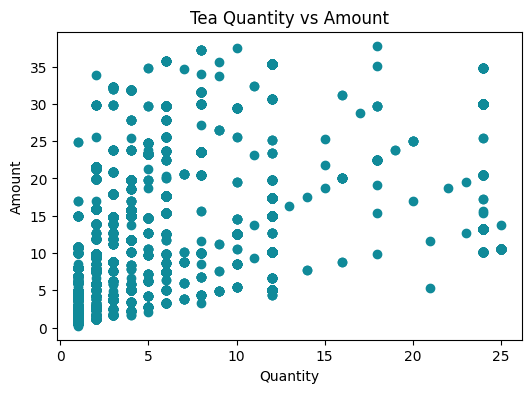

In [53]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(df_tea_only['quantity'], df_tea_only['amount'], c='#108A99', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Tea Quantity vs Amount')
plt.show()

In [54]:
#Scatter Plot Coffee
df_cof_only = df_clean[df_clean['product_name'].str.contains('coffee')]
df_cof_only.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,year_month,amount,order_status,bin1,bin2,bin3,bin4,bin5,price_class
362,493444,21869,potting shed coffee mug,2,2010-01-04 13:47:00,1.25,16792.0,2010-01-04,2010-01,2.50,delivered,"(0.001, 5.001]",Cheap,Cheap,Cheap,"(0.0, 4.068]",1. Cheap Coffee
505,493536,72122,coffee scent pillar candle,1,2010-01-04 15:29:00,0.95,17841.0,2010-01-04,2010-01,0.95,delivered,"(0.001, 5.001]",Cheap,Cheap,Cheap,"(0.0, 4.068]",1. Cheap Coffee
573,493543,72122,coffee scent pillar candle,7,2010-01-04 16:29:00,0.95,14839.0,2010-01-04,2010-01,6.65,delivered,"(0.001, 5.001]",Cheap,Cheap,Cheap,"(0.0, 4.068]",1. Cheap Coffee
920,493671,37370,retro coffee mugs assorted,12,2010-01-05 12:25:00,1.25,13338.0,2010-01-05,2010-01,15.00,delivered,"(0.001, 5.001]",Cheap,Cheap,Cheap,"(0.0, 4.068]",1. Cheap Coffee
1073,493695,21398,red spotty coffee mug,1,2010-01-05 13:23:00,2.10,14606.0,2010-01-05,2010-01,2.10,delivered,"(0.001, 5.001]",Cheap,Medium,Cheap,"(0.0, 4.068]",1. Cheap Coffee


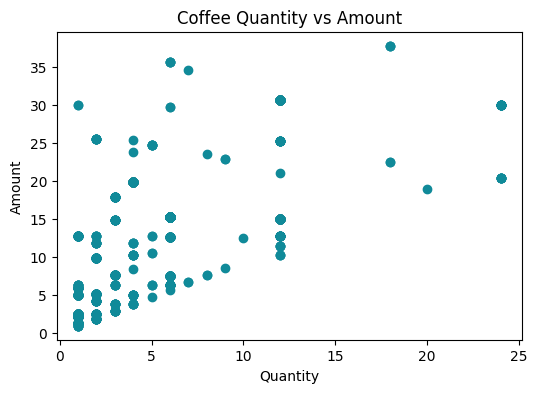

In [55]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(df_cof_only['quantity'], df_cof_only['amount'], c='#108A99', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Coffee Quantity vs Amount')
plt.show()

#Membuat user retention cohort

1. Agregat data transaksi ke bentuk summary total transaksi/order setiap pengguna setiap bulan

In [56]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-03,1
1,12346.0,2010-06,2
2,12346.0,2010-10,1
3,12608.0,2010-10,1
4,12745.0,2010-05,1
...,...,...,...
11328,18286.0,2010-06,1
11329,18286.0,2010-08,1
11330,18287.0,2010-05,1
11331,18287.0,2010-09,2


2. Buat kolom sebagai cohort dari pengguna, misal cohort bulan pertama kali bertransaksi

In [57]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-03,1,2010-03
1,12346.0,2010-06,2,2010-03
2,12346.0,2010-10,1,2010-03
3,12608.0,2010-10,1,2010-10
4,12745.0,2010-05,1,2010-05
...,...,...,...,...
11328,18286.0,2010-06,1,2010-06
11329,18286.0,2010-08,1,2010-06
11330,18287.0,2010-05,1,2010-05
11331,18287.0,2010-09,2,2010-05


3. Hitung jarak bulan antara bulan transaksi dengan bulan pertama kali transaksi dan jumlahkan dengan 1 agar jarak bulan 0 menjadi 1 yang berarti bulan pertama, dst.

In [58]:
df_user_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11333 entries, 0 to 11332
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  11333 non-null  object
 1   year_month   11333 non-null  object
 2   order_cnt    11333 non-null  int64 
 3   cohort       11333 non-null  object
dtypes: int64(1), object(3)
memory usage: 354.3+ KB


In [59]:
df_user_monthly['year_month'] = pd.to_datetime(df_user_monthly['year_month']).dt.to_period('M')
df_user_monthly['cohort'] = pd.to_datetime(df_user_monthly['cohort']).dt.to_period('M')
df_user_monthly['period_num'] = (df_user_monthly['year_month'].dt.month - df_user_monthly['cohort'].dt.month) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-03,1,2010-03,1
1,12346.0,2010-06,2,2010-03,4
2,12346.0,2010-10,1,2010-03,8
3,12608.0,2010-10,1,2010-10,1
4,12745.0,2010-05,1,2010-05,1
...,...,...,...,...,...
11328,18286.0,2010-06,1,2010-06,1
11329,18286.0,2010-08,1,2010-06,3
11330,18287.0,2010-05,1,2010-05,1
11331,18287.0,2010-09,2,2010-05,5


4. Tabel pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [60]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,661.0,249.0,307.0,280.0,270.0,273.0,262.0,240.0,252.0,281.0,299.0,224.0
2010-02,450.0,149.0,129.0,161.0,148.0,116.0,116.0,152.0,149.0,163.0,95.0,NaN
2010-03,502.0,134.0,147.0,138.0,130.0,110.0,136.0,175.0,183.0,96.0,NaN,NaN
2010-04,313.0,76.0,75.0,60.0,65.0,75.0,100.0,103.0,47.0,NaN,NaN,NaN
2010-05,266.0,49.0,44.0,49.0,44.0,66.0,63.0,37.0,NaN,NaN,NaN,NaN
2010-06,263.0,49.0,55.0,58.0,60.0,80.0,37.0,NaN,NaN,NaN,NaN,NaN
2010-07,175.0,36.0,39.0,51.0,55.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,34.0,46.0,48.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,219.0,61.0,58.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5. Hitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot tadi dengan nilai tersebut sebagai retention rate

In [61]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

,1
cohort,
2010-01,661.0
2010-02,450.0
2010-03,502.0
2010-04,313.0
2010-05,266.0
2010-06,263.0
2010-07,175.0
2010-08,160.0
2010-09,219.0


In [62]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.376702,0.464448,0.423601,0.408472,0.413011,0.396369,0.363086,0.381241,0.425113,0.452345,0.33888
2010-02,1.0,0.331111,0.286667,0.357778,0.328889,0.257778,0.257778,0.337778,0.331111,0.362222,0.211111,NaN
2010-03,1.0,0.266932,0.292829,0.274900,0.258964,0.219124,0.270916,0.348606,0.364542,0.191235,NaN,NaN
2010-04,1.0,0.242812,0.239617,0.191693,0.207668,0.239617,0.319489,0.329073,0.150160,NaN,NaN,NaN
2010-05,1.0,0.184211,0.165414,0.184211,0.165414,0.248120,0.236842,0.139098,NaN,NaN,NaN,NaN
2010-06,1.0,0.186312,0.209125,0.220532,0.228137,0.304183,0.140684,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.205714,0.222857,0.291429,0.314286,0.165714,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.212500,0.287500,0.300000,0.162500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.278539,0.264840,0.141553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


6. Tampilkan tabel pivot yang sudah berisi nilai retention rate tersebut dalam heatmap

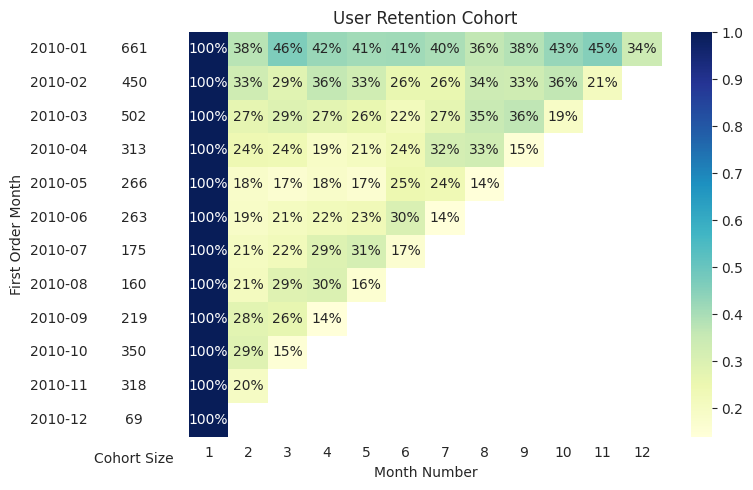

In [63]:
import matplotlib.colors as mcolors
with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(8,5), sharey=True, gridspec_kw={'width_ratios':[1, 8]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()

#plt.savefig('User Retention.png')

# Membuat RFM segmentation

1. Agregat data transaksi ke bentuk summary total transaksi (order), total nilai order (order value), tanggal order terakhir dari setiap pengguna

In [64]:
df_user = df_clean.groupby('customer_id', as_index=False).agg(order_cnt=('order_id','nunique'),max_order_date=('date','max'),total_order_value=('amount','sum'))
df_user

,customer_id,order_cnt,max_order_date,total_order_value
0,12346.0,4,2010-10-04,251.95
1,12608.0,1,2010-10-31,95.05
2,12745.0,2,2010-08-10,364.33
3,12746.0,2,2010-06-30,266.35
4,12747.0,19,2010-12-13,1957.17
...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37
3742,18284.0,2,2010-10-06,311.88
3743,18285.0,1,2010-02-17,173.00
3744,18286.0,2,2010-08-20,849.32


2. Buat kolom jumlah hari sejak order terakhir

In [65]:
today = df_clean['date'].max()
df_user['day_since_last_order'] = (today - df_user['max_order_date']).apply(lambda x: x.days)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order
0,12346.0,4,2010-10-04,251.95,80
1,12608.0,1,2010-10-31,95.05,53
2,12745.0,2,2010-08-10,364.33,135
3,12746.0,2,2010-06-30,266.35,176
4,12747.0,19,2010-12-13,1957.17,10
...,...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37,31
3742,18284.0,2,2010-10-06,311.88,78
3743,18285.0,1,2010-02-17,173.00,309
3744,18286.0,2,2010-08-20,849.32,125


In [66]:
today

datetime.date(2010, 12, 23)

In [67]:
df_user.describe()

,order_cnt,total_order_value,day_since_last_order
count,3746.000000,3746.000000,3746.000000
mean,4.784036,928.902892,91.314202
std,7.680229,1511.244130,88.740126
min,1.000000,0.950000,0.000000
25%,1.000000,209.067500,25.000000
50%,3.000000,464.315000,58.000000
75%,6.000000,1094.130000,128.000000
max,148.000000,35831.390000,352.000000


3. Buat binning dari jumlah hari sejak order terakhir yang terdiri dari 5 bins dengan batas-batasnya merupakan min, P20, P40, P60, P80, max dan beri label 1 sampai 5 dari bin tertinggi ke terendah sebagai skor recency

In [68]:
df_user['recency_score'] = pd.cut(df_user['day_since_last_order'],
                                  bins=[df_user['day_since_last_order'].min(),
                                        np.percentile(df_user['day_since_last_order'], 20),
                                        np.percentile(df_user['day_since_last_order'], 40),
                                        np.percentile(df_user['day_since_last_order'], 60),
                                        np.percentile(df_user['day_since_last_order'], 80),
                                        df_user['day_since_last_order'].max()],
                                  labels=[5, 4, 3, 2, 1],
                                  include_lowest=True).astype(int)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score
0,12346.0,4,2010-10-04,251.95,80,2
1,12608.0,1,2010-10-31,95.05,53,3
2,12745.0,2,2010-08-10,364.33,135,2
3,12746.0,2,2010-06-30,266.35,176,1
4,12747.0,19,2010-12-13,1957.17,10,5
...,...,...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37,31,4
3742,18284.0,2,2010-10-06,311.88,78,2
3743,18285.0,1,2010-02-17,173.00,309,1
3744,18286.0,2,2010-08-20,849.32,125,2


In [69]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           3746 non-null   object 
 1   order_cnt             3746 non-null   int64  
 2   max_order_date        3746 non-null   object 
 3   total_order_value     3746 non-null   float64
 4   day_since_last_order  3746 non-null   int64  
 5   recency_score         3746 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 175.7+ KB


4. Buat binning dari jumlah hari sejak order terakhir yang terdiri dari 5 bins dengan fungsi qcut() dan beri label 1 sampai 5 dari bin tertinggi ke terendah sebagai skor frekuensi.

In [70]:
#df_user['frequency_score'] = pd.cut(df_user['order_cnt'],
#                                    bins=[df_user['order_cnt'].min(),
#                                          np.percentile(df_user['order_cnt'], 20),
#                                          np.percentile(df_user['order_cnt'], 40),
#                                          np.percentile(df_user['order_cnt'], 60),
#                                          np.percentile(df_user['order_cnt'], 80),
#                                          df_user['order_cnt'].max()],
#                                    labels=[1, 2, 3, 4, 5],
#                                    include_lowest=True, duplicates='drop').astype(int)

df_user['frequency_score'] = pd.qcut(df_user['order_cnt'], q=6, labels=[1, 2, 3, 4, 5], duplicates='drop')

#bins = np.linspace(min(df_user['order_cnt']), max(df_user['order_cnt']), 6)
#df_user['frequency_score'] = pd.cut(df_user['order_cnt'], bins, labels=[1, 2, 3, 4, 5], include_lowest=True)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score
0,12346.0,4,2010-10-04,251.95,80,2,3
1,12608.0,1,2010-10-31,95.05,53,3,1
2,12745.0,2,2010-08-10,364.33,135,2,1
3,12746.0,2,2010-06-30,266.35,176,1,1
4,12747.0,19,2010-12-13,1957.17,10,5,5
...,...,...,...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37,31,4,4
3742,18284.0,2,2010-10-06,311.88,78,2,1
3743,18285.0,1,2010-02-17,173.00,309,1,1
3744,18286.0,2,2010-08-20,849.32,125,2,1


In [71]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   customer_id           3746 non-null   object  
 1   order_cnt             3746 non-null   int64   
 2   max_order_date        3746 non-null   object  
 3   total_order_value     3746 non-null   float64 
 4   day_since_last_order  3746 non-null   int64   
 5   recency_score         3746 non-null   int64   
 6   frequency_score       3746 non-null   category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 179.6+ KB


5. Buat binning dari total nilai order (order value) yang terdiri dari 5 bins dengan batas-batasnya merupakan min, P20, P40, P60, P80, max dan beri label 1 sampai 5 dari bin terendah ke tertinggi sebagai skor monetary

In [72]:
df_user['monetary_score'] = pd.cut(df_user['total_order_value'],
                                   bins=[df_user['total_order_value'].min(),
                                         np.percentile(df_user['total_order_value'], 20),
                                         np.percentile(df_user['total_order_value'], 40),
                                         np.percentile(df_user['total_order_value'], 60),
                                         np.percentile(df_user['total_order_value'], 80),
                                         df_user['total_order_value'].max()],
                                   labels=[1, 2, 3, 4, 5],
                                   include_lowest=True).astype(int)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score
0,12346.0,4,2010-10-04,251.95,80,2,3,2
1,12608.0,1,2010-10-31,95.05,53,3,1,1
2,12745.0,2,2010-08-10,364.33,135,2,1,3
3,12746.0,2,2010-06-30,266.35,176,1,1,2
4,12747.0,19,2010-12-13,1957.17,10,5,5,5
...,...,...,...,...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37,31,4,4,3
3742,18284.0,2,2010-10-06,311.88,78,2,1,2
3743,18285.0,1,2010-02-17,173.00,309,1,1,2
3744,18286.0,2,2010-08-20,849.32,125,2,1,4


In [73]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   customer_id           3746 non-null   object  
 1   order_cnt             3746 non-null   int64   
 2   max_order_date        3746 non-null   object  
 3   total_order_value     3746 non-null   float64 
 4   day_since_last_order  3746 non-null   int64   
 5   recency_score         3746 non-null   int64   
 6   frequency_score       3746 non-null   category
 7   monetary_score        3746 non-null   int64   
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 208.8+ KB


6. Buat kolom nama segmen berdasarkan skor recency dan frequency

In [74]:
df_user['segment'] = np.select(
    [(df_user['recency_score']==5) & (df_user['frequency_score']>=4),
     (df_user['recency_score'].between(3, 4)) & (df_user['frequency_score']>=4),
     (df_user['recency_score']>=4) & (df_user['frequency_score'].between(2, 3)),
     (df_user['recency_score']<=2) & (df_user['frequency_score']==5),
     (df_user['recency_score']==3) & (df_user['frequency_score']==3),
     (df_user['recency_score']==5) & (df_user['frequency_score']==1),
     (df_user['recency_score']==4) & (df_user['frequency_score']==1),
     (df_user['recency_score']<=2) & (df_user['frequency_score'].between(3, 4)),
     (df_user['recency_score']==3) & (df_user['frequency_score']<=2),
     (df_user['recency_score']<=2) & (df_user['frequency_score']<=2)],
    ['01-Champion', '02-Loyal Customers', '03-Potential Loyalists', "04-Can't Lose Them", '05-Need Attention',
     '06-New Customers', '07-Promising', '08-At Risk', '09-About to Sleep', '10-Hibernating']
)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,day_since_last_order,recency_score,frequency_score,monetary_score,segment
0,12346.0,4,2010-10-04,251.95,80,2,3,2,08-At Risk
1,12608.0,1,2010-10-31,95.05,53,3,1,1,09-About to Sleep
2,12745.0,2,2010-08-10,364.33,135,2,1,3,10-Hibernating
3,12746.0,2,2010-06-30,266.35,176,1,1,2,10-Hibernating
4,12747.0,19,2010-12-13,1957.17,10,5,5,5,01-Champion
...,...,...,...,...,...,...,...,...,...
3741,18283.0,6,2010-11-22,619.37,31,4,4,3,02-Loyal Customers
3742,18284.0,2,2010-10-06,311.88,78,2,1,2,10-Hibernating
3743,18285.0,1,2010-02-17,173.00,309,1,1,2,10-Hibernating
3744,18286.0,2,2010-08-20,849.32,125,2,1,4,10-Hibernating


In [75]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746 entries, 0 to 3745
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   customer_id           3746 non-null   object  
 1   order_cnt             3746 non-null   int64   
 2   max_order_date        3746 non-null   object  
 3   total_order_value     3746 non-null   float64 
 4   day_since_last_order  3746 non-null   int64   
 5   recency_score         3746 non-null   int64   
 6   frequency_score       3746 non-null   category
 7   monetary_score        3746 non-null   int64   
 8   segment               3746 non-null   object  
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 238.1+ KB


7. Tampilkan summary dari RFM segmentation (poin 8) berupa banyaknya pengguna, rata-rata dan median dari total order, total order value, dan jumlah hari sejak order terakhir

In [76]:
summary = pd.pivot_table(df_user, index='segment',
               values=['customer_id','day_since_last_order','order_cnt','total_order_value'],
               aggfunc={'customer_id': pd.Series.nunique,
                        'day_since_last_order': [np.mean, np.median],
                        'order_cnt': [np.mean, np.median],
                        'total_order_value': [np.mean, np.median]})
summary['pct_unique'] = (summary['customer_id'] / summary['customer_id'].sum() * 100).round(1)
summary

customer_id day_since_last_order         order_cnt  \
                           nunique                 mean median       mean   
segment                                                                     
01-Champion                    505            10.627723    9.0  14.378218   
02-Loyal Customers             521            41.744722   38.0   8.483685   
03-Potential Loyalists         289            23.193772   23.0   3.453287   
04-Can't Lose Them              34           115.852941  110.5  12.705882   
05-Need Attention               76            58.736842   59.5   4.000000   
06-New Customers               131            12.404580   13.0   1.595420   
07-Promising                   291            32.092784   32.0   1.501718   
08-At Risk                     237           136.776371  119.0   5.050633   
09-About to Sleep              468            59.587607   59.0   1.775641   
10-Hibernating                1194           191.435511  190.0   1.534338   

                              total_order_value           pct_unique  
                       median              mean    median             
segment                                                               
01-Champion              10.0       2682.340921  1861.930       13.5  
02-Loyal Customers        7.0       1703.405092  1380.480       13.9  
03-Potential Loyalists    3.0        693.664429   570.180        7.7  
04-Can't Lose Them       10.0       2244.443529  1494.455        0.9  
05-Need Attention         4.0        861.900000   740.195        2.0  
06-New Customers          2.0        347.595420   264.520        3.5  
07-Promising              2.0        303.660034   258.830        7.8  
08-At Risk                5.0        927.159582   815.350        6.3  
09-About to Sleep         2.0        415.152481   320.055       12.5  
10-Hibernating            1.0        290.955832   217.170       31.9

In [77]:
#summary['order_cnt']['mean']

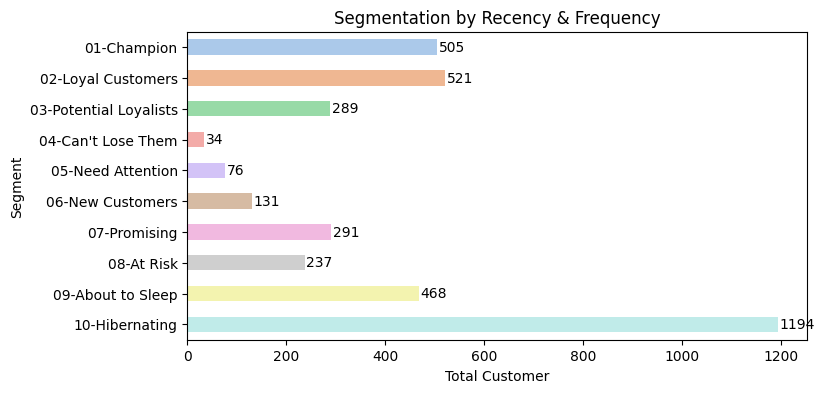

In [78]:
fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(y='segment', x=summary['customer_id']['nunique'], data=summary, palette='pastel', width=0.5, orient='h')
plt.ylabel('Segment')
plt.xlabel('Total Customer')
plt.title('Segmentation by Recency & Frequency')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', padding=1)
plt.show()

#Market Basket Analysis

1. Buat dataframe basket

In [79]:
basket = pd.pivot_table(df_clean, index='order_id', columns='product_name', values='product_code', aggfunc='nunique', fill_value=0)
basket

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C539945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C539947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C539949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2. Encode DataFrame basket dengan nilai True untuk semua nilai di atas 0 dan False untuk semua nilai 0

In [80]:
def encode(x):
    if x==0:
        return False
    if x>0:
        return True

basket_encode = basket.applymap(encode)
basket_encode

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C539945,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C539947,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C539949,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


3. Ambil transaksi dengan banyaknya produk unik lebih dari 1 saja

In [81]:
basket_filter = basket_encode[(basket_encode>0).sum(axis=1)>1]
basket_filter

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C539711,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C539719,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C539943,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


4. Mengaplikasikan apriori algorithm

Buat list frequent itemset (kumpulan produk yang sering dibeli)

In [82]:
!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemset = apriori(basket_filter, min_support=.01, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemset['product_cnt'] = frequent_itemset['itemsets'].apply(lambda x: len(x))
frequent_itemset

,support,itemsets,product_cnt
0,0.136835,(white hanging heart t-light holder),1
1,0.071820,(jumbo bag red retrospot),1
2,0.071160,(strawberry ceramic trinket box),1
3,0.070565,(lunch bag red spotty),1
4,0.068252,(pack of 72 retro spot cake cases),1
...,...,...,...
938,0.010043,(camouflage led torch),1
939,0.010043,(cinammon set of 9 t-lights),1
940,0.010043,(alphabet stencil craft),1
941,0.010043,"(ladies & gentlemen metal sign, please one per...",2


Hitung nilai support, confidence, dan lift dari setiap pasangan produk yang mungkin

In [83]:
product_association = association_rules(frequent_itemset, metric='confidence', min_threshold=.7).sort_values(['support','confidence'], ascending=[False,False]).reset_index(drop=True)
product_association

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(sweetheart ceramic trinket box),(strawberry ceramic trinket box),0.045920,0.071160,0.034093,0.742446,10.433538,0.030826,3.606392,0.947672
1,(toilet metal sign),(bathroom metal sign),0.026891,0.040040,0.021473,0.798526,19.943379,0.020397,4.764681,0.976107
2,(kitchen metal sign),(bathroom metal sign),0.019689,0.040040,0.016122,0.818792,20.449532,0.015333,5.297559,0.970202
3,(red retrospot sugar jam bowl),(red retrospot small milk jug),0.022795,0.037199,0.015989,0.701449,18.856900,0.015141,3.224917,0.969059
4,"(key fob , back door )","(key fob , shed)",0.020747,0.024050,0.015395,0.742038,30.853704,0.014896,3.783312,0.988088
5,(set/10 blue spotty party candles),(set/10 pink spotty party candles),0.018963,0.023059,0.015329,0.808362,35.056059,0.014891,5.097855,0.990252
6,"(key fob , garage design)","(key fob , shed)",0.018698,0.024050,0.015064,0.805654,33.498816,0.014615,5.021705,0.988634
7,(poppy's playhouse bedroom),(poppy's playhouse kitchen),0.016716,0.018698,0.014866,0.889328,47.561768,0.014554,8.866761,0.995618
8,(poppy's playhouse kitchen),(poppy's playhouse bedroom),0.018698,0.016716,0.014866,0.795053,47.561768,0.014554,4.797747,0.997629
9,(poppy's playhouse livingroom),(poppy's playhouse kitchen),0.014668,0.018698,0.013413,0.914414,48.903400,0.013138,11.465735,0.994133
